In [1]:
# Imports + my helper functions

import sys
import os
import xarray as xr
import netCDF4 as nc
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import importlib
import matplotlib.colors as mcolors
from collections import Counter

sys.path.append('/home/563/ls7238/code/australia_precipitation/module')
import helper_funcs
importlib.reload(helper_funcs)


<module 'helper_funcs' from '/home/563/ls7238/code/australia_precipitation/module/helper_funcs.py'>

In [3]:
# Make list of the file paths

base_dir = '/g/data/k10/dl6968/BoM_gauges/netcdf/30min_inst'  
nc_files = []

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith('.nc'):
            nc_files.append(os.path.join(root, file))

print(nc.Dataset(nc_files[0]))
  

<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Record_identifier: st
    Station_Number: 068241
    Rainfall_district_code: 68
    Station_Name: ALBION PARK (SHELLHARBOUR AIRPORT)      
    Station_opened(MM-YYYY): 06/1999
    Station_closed(MM-YYYY):        
    Latitude: -34.5639
    Longitude: 150.7924
    lat-lon_record_method:                
    State: NSW
    Height_station(ABSL): 8.0
    Height_barometer(ABSL):    8.5
    WMO_Number: 95748
    First_year: 1999
    Lastest_year: 2024
    Percentage_of_complete: 83
    Percentage_of_Y: 0
    Percentage_of_N: 100
    Percentage_of_W: 0
    Percentage_of_S: 0
    Percentage_of_I: 0
    EoR_indicator: #
    author: Dongqi Lin (dongqi.lin@monash.edu)
    dimensions(sizes): time(440307)
    variables(dimensions): int64 time(time), float64 prcp(time), <class 'str'> local_time(time), int64 aws_flag(time), float64 quality_flag(time), float64 prcp_inst(time)
    groups: 


In [4]:
# Pull out station metadata for later plotting:

metadata_df = helper_funcs.read_stations_metadata(nc_files)

In [5]:
metadata_df

,Station Number,Station Name,State,Latitude,Longitude,Start Year,End Year,Percentage Complete (from file),Record Length
0,068241,ALBION PARK (SHELLHARBOUR AIRPORT),NSW,-34.5639,150.7924,1999,2024,83.0,26
1,061366,NORAH HEAD AWS,NSW,-33.2814,151.5766,1989,2024,80.0,36
2,069128,NERRIGA AWS,NSW,-35.1103,150.0826,2013,2024,99.0,12
3,065070,DUBBO AIRPORT AWS,NSW,-32.2206,148.5753,1989,2024,67.0,36
4,048244,COBAR COMPARISON,NSW,-31.4861,145.8281,2000,2000,60.0,1
...,...,...,...,...,...,...,...,...,...
635,014310,OENPELLI AIRPORT,NT,-12.3272,133.0069,2012,2024,97.0,13
636,015135,TENNANT CREEK AIRPORT,NT,-19.6423,134.1833,1990,2024,72.0,35
637,014704,MCARTHUR RIVER MINE AIRPORT,NT,-16.4423,136.0760,2003,2024,81.0,22
638,014309,MURGANELLA AIRSTRIP,NT,-11.5485,132.9266,2012,2024,97.0,13


In [6]:
# Function for reading an nc file, summing annual totals, and then adding to a df.

def annual_rainfall_sum(nc_files):
    """
    Calculate annual rainfall statistics from half-hourly station NetCDF files.
    Argument: nc_files -- is a list of strings of file names
    """
    annual_data = {}

    for file in nc_files:
        ds = xr.open_dataset(file)
        rain = ds["prcp_inst"]

        # Convert to pandas DataFrame with datetime index
        df = rain.to_pandas()
        df.index = pd.to_datetime(df.index)

        # Annual aggregation
        daily = df.resample("D").sum(min_count=1)
        yearly = daily.resample("YE").sum(min_count=1)

        # Ensure index is years
        yearly.index = yearly.index.year
        yearly = pd.Series(yearly.squeeze(), index=yearly.index)

        # Station ID:
        station_id = ds.attrs.get("Station_Number")
        annual_data[station_id] = yearly

        ds.close()

    # Combine into DataFrame
    annual_df = pd.concat(annual_data, axis=1)
    annual_df.index.name = "Year"
    annual_df = annual_df.sort_index()

    return annual_df



In [7]:
# Function for averaging across the time series and combining with the lat and lon:

def mean_raindfs(metadata_df, annualrain_df):
    '''
    Function that takes one df that contains metadata and another that contains rainfall values, 
    then averages annual totals per station and merges them with metadata.

    Arguments:
    metadata_df - DataFrame
        Must at least contain columns ['Station Number', 'Latitude', 'Longitude']
    annualrain_df - DataFrame
        Index = Year, columns = Station Numbers, values = annual rainfall.

    Returns: DataFrame with Station Number, Latitude, Longitude, and Mean Rain.
    '''

    # Collapse to mean rainfall per station first
    station_means = (
        annualrain_df.mean(axis=0, skipna=True)   # mean over years
        .reset_index()
        .rename(columns={"index": "Station Number", 0: "Mean Rain"})
    )

    # Merge with metadata (only one row per station now)
    metadata_filtered = metadata_df[["Station Number", "Latitude", "Longitude"]]
    merged = station_means.merge(metadata_filtered, on="Station Number", how="left")

    return merged


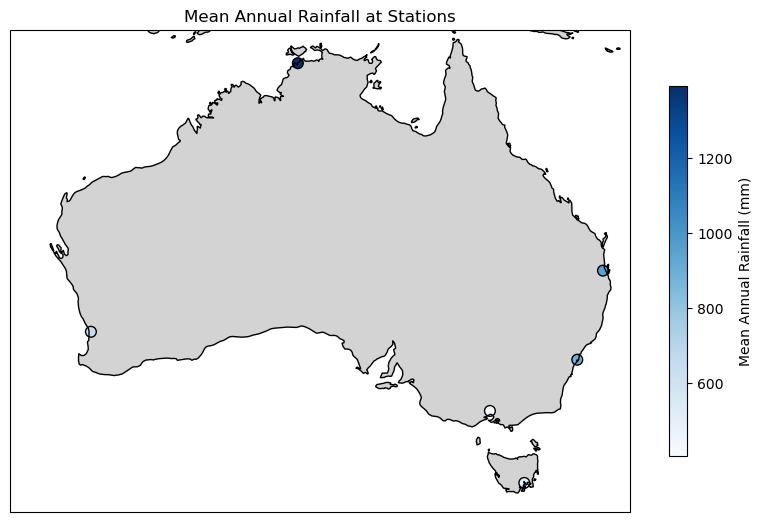

In [8]:
# Pulling out capital city longest running stations for testing

# ID: 066037	Name: SYDNEY AIRPORT AMO
# ID: 086282	Name: MELBOURNE AIRPORT
# ID: 014015	Name: DARWIN AIRPORT
# ID: 040913	Name: BRISBANE
# ID: 009225	Name: PERTH METRO
# ID: 094029	Name: HOBART (ELLERSLIE ROAD)

tester_stations = ['/g/data/k10/dl6968/BoM_gauges/netcdf/30min_inst/NSW/NSW_066037.nc', #0
                        '/g/data/k10/dl6968/BoM_gauges/netcdf/30min_inst/VIC/VIC_086282.nc', #1
                        '/g/data/k10/dl6968/BoM_gauges/netcdf/30min_inst/NT/NT_014015.nc',   #2
                        '/g/data/k10/dl6968/BoM_gauges/netcdf/30min_inst/QLD/QLD_040913.nc',  #3
                        '/g/data/k10/dl6968/BoM_gauges/netcdf/30min_inst/WA/WA_009225.nc',    #4
                        '/g/data/k10/dl6968/BoM_gauges/netcdf/30min_inst/TAS/TAS_094029.nc']

test = annual_rainfall_sum(tester_stations)

test_means = mean_raindfs(metadata_df, test)


# Plot
fig, ax = plt.subplots(figsize=(10,8), 
                       subplot_kw={'projection': ccrs.PlateCarree()})

# Add land, coastlines, and borders
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set extent to Australia
ax.set_extent([110, 155, -45, -10], crs=ccrs.PlateCarree())

# Scatter plot of station means
sc = ax.scatter(
    test_means["Longitude"], 
    test_means["Latitude"], 
    c=test_means["Mean Rain"], 
    cmap="Blues", 
    s=60, 
    edgecolor="k", 
    transform=ccrs.PlateCarree()
)

# Colorbar
cbar = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.6)
cbar.set_label("Mean Annual Rainfall (mm)")

plt.title("Mean Annual Rainfall at Stations")
plt.show()


In [9]:
# Run full list of stations through the functions:

# Creating annual rainfall df
annualrain_df = helper_funcs.rainfall_sum(nc_files, timescale='yearly')

In [10]:
annualrain_df

,068241,061366,069128,065070,048244,074037,065111,063308,069132,061087,...,014405,014948,014031,014703,014308,014310,015135,014704,014309,014272
time,,,,,,,,,,,,,,,,,,,,,
1948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,1250.8,2915.6,956.8,784.0,NaN,462.6,738.4,1021.4,892.6,NaN,...,1397.2,1171.6,1521.2,1398.4,1332.0,1420.0,549.8,1298.8,1468.2,1360.6
2021,1114.2,1354.8,1052.4,911.2,NaN,521.0,948.8,955.6,1229.0,NaN,...,1530.8,1373.4,1664.8,859.6,1432.4,1589.6,278.6,772.2,1428.2,1197.4
2022,2548.8,1486.2,1103.2,1016.6,NaN,563.0,962.4,1324.2,1006.8,NaN,...,1207.8,1773.2,1543.6,463.4,1411.8,1408.0,612.0,644.0,1458.4,1586.8


In [11]:
# Averaging annual rainfall df over timeseries:
avg_annual_rain = mean_raindfs(metadata_df, annualrain_df)

In [12]:
# Function that can make annual / average annual rainfall plots for a given year / time period and given region:

def annual_rainfall_plot(time_period='all', figure_title="Avergae Annual Rainfall Map", region="aus", ax = None):
    """
    Produces a rainfall map for:
    - 'all' : average across all years
    - int   : a single year
    - tuple : a range of years (inclusive)

    region:
    - 'aus' (default): whole Australia
    - capital city codes: 'syd','mel','bne','per','hob','dar'

    ax: (optional) axes to plot into, if None, a new figure is created - for creating subplots
    """

    # Define colour bar so it is like the BOM non-linear one
    bounds = [0, 50, 100, 200, 300, 400, 600, 1000, 1500, 2000, 3000, 3500]
    cmap_r = plt.get_cmap("YlGnBu", len(bounds)-1)  
    norm_r = mcolors.BoundaryNorm(boundaries=bounds, ncolors=cmap_r.N)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10,8), subplot_kw={'projection': ccrs.PlateCarree()})
    else:
        fig = ax.figure

    # Add features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor="white")  
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

    # Regions
    extents = {
        "aus": [110, 155, -45, -10],
        "syd": [149, 152, -35, -32],
        "mel": [144, 146, -39, -37],
        "bne": [151, 154, -29, -26],
        "per": [114, 116.5, -33.5, -31],
        "hob": [146, 148, -43.5, -41.5],
        "dar": [130, 132.5, -13.5, -11.5],
    }
    ax.set_extent(extents.get(region, extents["aus"]), crs=ccrs.PlateCarree())

    # Data selection for chosen time period / year
    if time_period == 'all':
        # whole period we have data for
        data = avg_annual_rain["Mean Rain"]

    elif isinstance(time_period, int):
        # single year
        data = annualrain_df.loc[time_period].reindex(metadata_df["Station Number"].values)

    elif isinstance(time_period, tuple) and len(time_period) == 2:
        # pre-defined period of years
        start, end = time_period
        data = annualrain_df.loc[start:end].mean().reindex(metadata_df["Station Number"].values)

    else:
        raise ValueError("time_period must be 'all', a single year (int), or a (start, end) tuple")

    # Make the actual points from the data
    sc = ax.scatter(
        metadata_df["Longitude"], 
        metadata_df["Latitude"], 
        c=data.values, 
        cmap=cmap_r,
        norm=norm_r,
        s=30,  
        transform=ccrs.PlateCarree()
    )

    # Colorbar
    cbar = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.6)
    cbar.set_label("Mean Annual Rainfall (mm)")
     
    ax.set_title(figure_title)

    return fig, ax




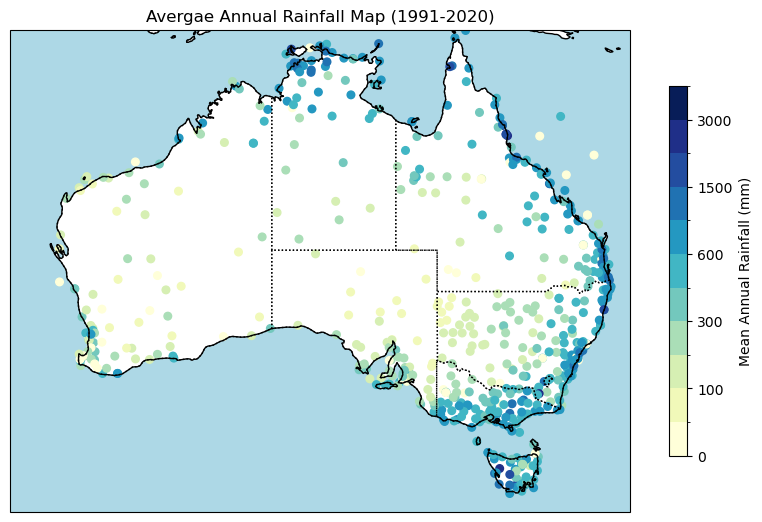

In [13]:
#Testing one region at a time:

fig, ax = annual_rainfall_plot(time_period=(1991, 2020), figure_title="Avergae Annual Rainfall Map (1991-2020)", region="aus")

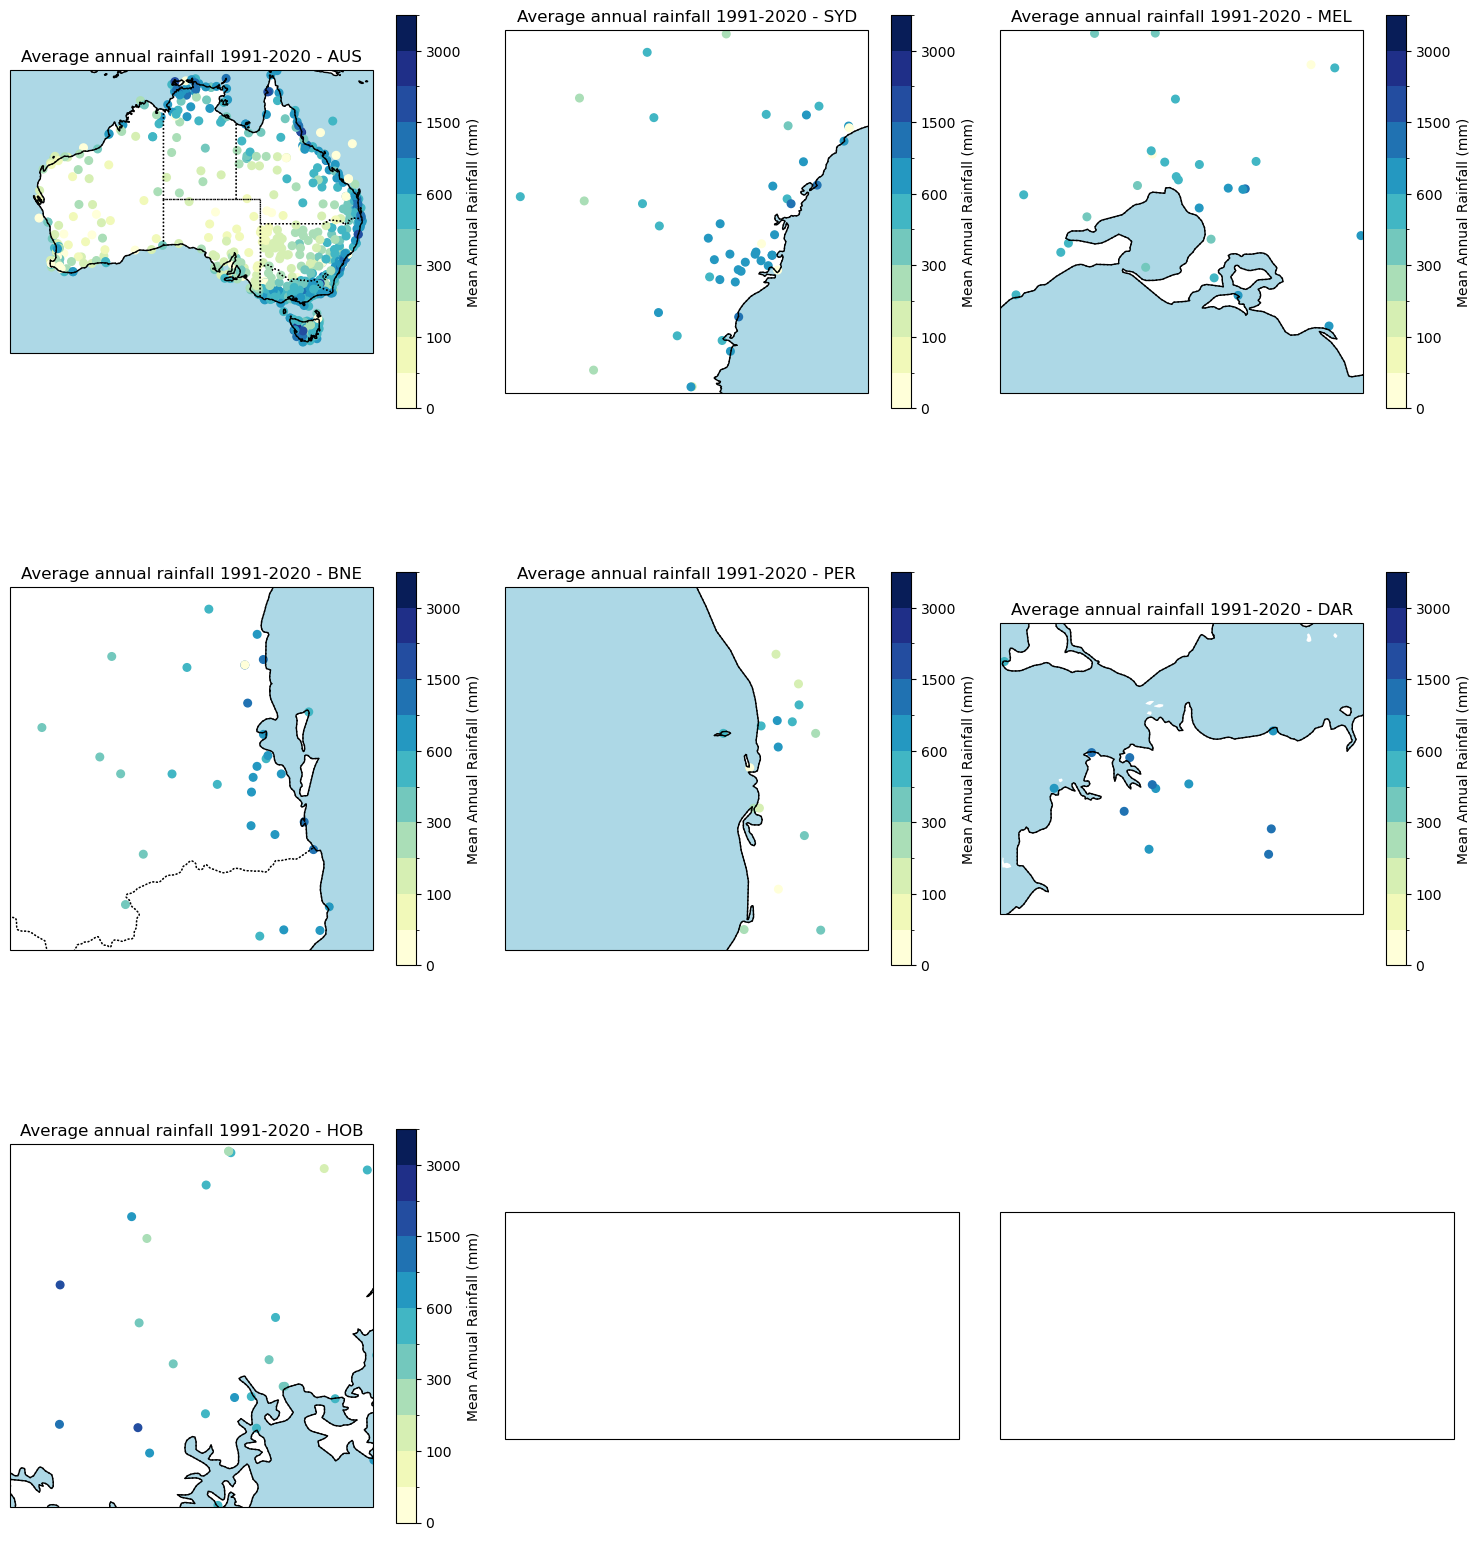

In [14]:
# Plotting all cities next to each other:

regions_to_plot = ["aus", "syd", "mel", "bne", "per", "dar", "hob"]

# Calculate number of columns needed
n = len(regions_to_plot)
rows = 3
cols = (n + rows - 1) // rows  

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 6*rows), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flat 

for ax, region in zip(axes, regions_to_plot): 
    annual_rainfall_plot(time_period=(1991,2020), region=region, ax=ax, figure_title=f"Average annual rainfall 1991-2020 - {region.upper()}")

# Remove any unused axes if the grid is bigger than number of regions
for ax in list(axes)[n:]:
    ax.remove()

plt.tight_layout()
#plt.savefig('Average annual rainfall 1991-2020 across all cities')
plt.show()


In [15]:
# modifying my earlier function to pull out the daily values:

def rainfall_sum(nc_files, timescale='yearly'):
    """
    Calculate rainfall sums from half-hourly station NetCDF files.

    Arguments: 
    - nc_files: list of NetCDF file paths
    - timescale: 'yearly' or 'daily'
    """
    data = {}

    for file in nc_files:
        ds = xr.open_dataset(file)
        rain = ds["prcp_inst"]

        # Convert to pandas with datetime index
        df = rain.to_pandas()
        df.index = pd.to_datetime(df.index)

        # Resample to daily totals first
        daily = df.resample("D").sum(min_count=1)

        if timescale == 'daily':
            out = daily
        elif timescale == 'yearly':
            yearly = daily.resample("YE").sum(min_count=1)
            yearly.index = yearly.index.year
            out = pd.Series(yearly.squeeze(), index=yearly.index)
        else:
            raise ValueError("timescale must be 'daily' or 'yearly'")

        # Station ID
        station_id = ds.attrs.get("Station_Number")
        data[station_id] = out

        ds.close()

    # Combine into one DataFrame
    combined_df = pd.concat(data, axis=1)
    combined_df = combined_df.sort_index()
    return combined_df


In [16]:
daily_df = helper_funcs.rainfall_sum(nc_files, timescale='daily')

KeyboardInterrupt: 

In [ ]:
daily_df

,068241,061366,069128,065070,048244,074037,065111,063308,069132,061087,...,014405,014948,014031,014703,014308,014310,015135,014704,014309,014272
time,,,,,,,,,,,,,,,,,,,,,
1948-10-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-10-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-10-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-10-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-10-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-11,0.0,0.0,0.2,0.2,NaN,1.4,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-07-12,0.0,0.0,0.0,0.2,NaN,0.8,0.0,0.2,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-07-13,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Quality Control

In [ ]:
# Flatten + clean daily rainfall
all_daily = daily_df.values.flatten()
all_daily = all_daily[~np.isnan(all_daily)]
all_daily = all_daily[all_daily > 0.1]

# Compute 99th percentile
p99 = np.percentile(all_daily, 99)
p99_9 = np.percentile(all_daily, 99.9)

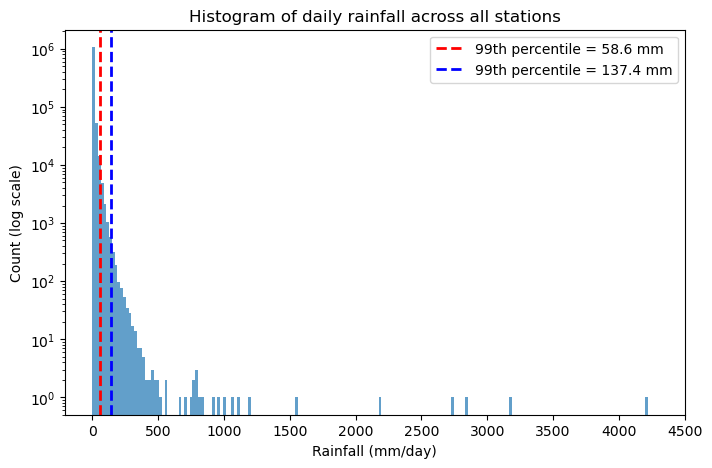

In [ ]:
# Plot histogram of all daily rainfall

plt.figure(figsize=(8,5))
plt.hist(all_daily, bins=200, alpha = 0.7)
plt.yscale("log")
plt.xlabel("Rainfall (mm/day)")
plt.ylabel("Count (log scale)")
plt.title("Histogram of daily rainfall across all stations")

# Add vertical line for percentiles
plt.axvline(p99, color="red", linestyle="--", linewidth=2, label=f"99th percentile = {p99:.1f} mm")
plt.axvline(p99_9, color="blue", linestyle="--", linewidth=2, label=f"99th percentile = {p99_9:.1f} mm")

max_val = all_daily.max()
plt.xticks(np.arange(0, max_val+500, 500))

plt.legend()
plt.show()

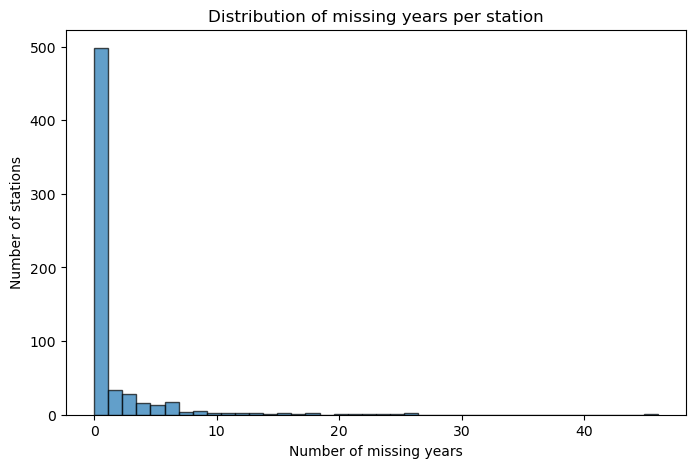

In [17]:
# Looking for stations that have long periods of no data years:

# number of nans per station (in their recording period)
nan_counts = {}
for station in annualrain_df.columns:
    start_year = metadata_df.loc[metadata_df['Station Number'] == station, 'Start Year'].values[0]
    end_year   = metadata_df.loc[metadata_df['Station Number'] == station, 'End Year'].values[0]
    station_data = annualrain_df[station].loc[start_year:end_year]
    nan_counts[station] = station_data.isna().sum()

nan_counts = pd.Series(nan_counts)


plt.figure(figsize=(8,5))
plt.hist(nan_counts, bins=40, edgecolor="k", alpha=0.7)
plt.xlabel("Number of missing years")
plt.ylabel("Number of stations")
plt.title("Distribution of missing years per station")
plt.show()

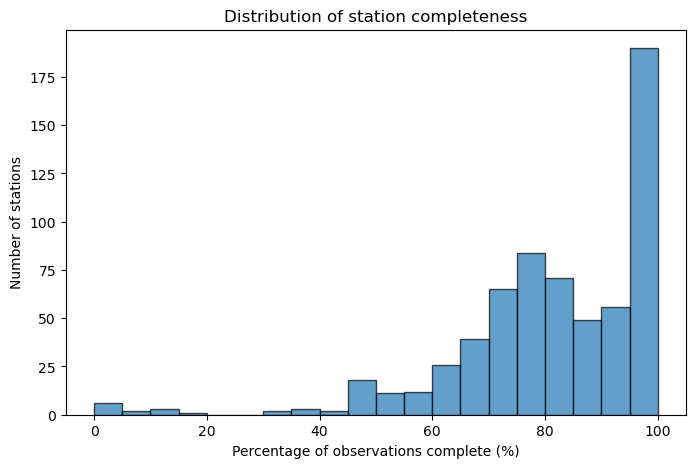

In [18]:
# finally plotting % complete:

plt.figure(figsize=(8,5))
plt.hist(metadata_df['Percentage Complete (from file)'], bins=20, edgecolor="k", alpha=0.7)
plt.xlabel("Percentage of observations complete (%)")
plt.ylabel("Number of stations")
plt.title("Distribution of station completeness")
plt.show()


In [5]:
tester_stations = ['/g/data/k10/dl6968/BoM_gauges/netcdf/30min_inst/NSW/NSW_066037.nc', #0
                        '/g/data/k10/dl6968/BoM_gauges/netcdf/30min_inst/VIC/VIC_086282.nc', #1
                        '/g/data/k10/dl6968/BoM_gauges/netcdf/30min_inst/NT/NT_014015.nc',   #2
                        '/g/data/k10/dl6968/BoM_gauges/netcdf/30min_inst/QLD/QLD_040913.nc',  #3
                        '/g/data/k10/dl6968/BoM_gauges/netcdf/30min_inst/WA/WA_009225.nc',    #4
                        '/g/data/k10/dl6968/BoM_gauges/netcdf/30min_inst/TAS/TAS_094029.nc']

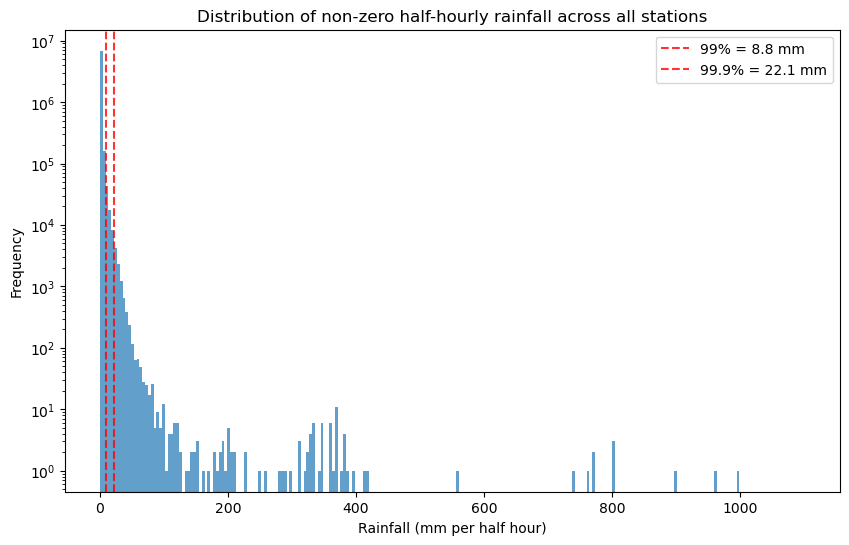

Maximum half-hourly rainfall value across all stations: 997.8mm


In [20]:
# Now checking the half-hourly data to find a threshold for suspicious values

# Define bins for histogram
bins = np.linspace(0, 1100, 250)  
hist_total = np.zeros(len(bins)-1)

max_vals= []

# Loop through files one at a time
for f in nc_files:
    try:
        with xr.open_dataset(f) as ds:
            # remove zeros and NaNs
            vals = ds['prcp_inst'].values.flatten()
            vals = vals[~np.isnan(vals)]
            vals = vals[vals > 0.1] 

            if vals.size == 0:
                continue 

            # Add values to hist
            hist, _ = np.histogram(vals, bins=bins)
            hist_total += hist

            # pull out max to check outliers
            max_vals.append(vals.max())
    except Exception as e:
        print(f"Skipping {f} due to error: {e}")

# Plot histogram
plt.figure(figsize=(10,6))
plt.bar(bins[:-1], hist_total, width=np.diff(bins), align='edge', alpha=0.7)
plt.yscale("log")
plt.xlabel("Rainfall (mm per half hour)")
plt.ylabel("Frequency")
plt.title("Distribution of non-zero half-hourly rainfall across all stations")

# Percentiles from histogram
cdf = np.cumsum(hist_total) / np.sum(hist_total)
percentiles = [99, 99.9]

for p in percentiles:
    idx = np.searchsorted(cdf, p/100)
    perc_val = bins[idx]
    plt.axvline(perc_val, color="red", linestyle="--", alpha=0.8, label=f"{p}% = {perc_val:.1f} mm")

plt.legend()
plt.show()

overall_max = max(max_vals) if max_vals else None
print(f"Maximum half-hourly rainfall value across all stations: {overall_max}mm")

In [6]:
# Now looking at sus values

threshold = 500  # mm per half-hour
suspicious = []

for f in nc_files:
    try:
        with xr.open_dataset(f) as ds:
            station = ds.attrs.get("Station_Number", f)
            rain = ds['prcp_inst']
            
            # Flatten to DataFrame with time
            df = rain.to_dataframe().reset_index()
            
            # Filter for suspicious values and make a copy
            sus_rows = df[df['prcp_inst'] > threshold].copy()
            if not sus_rows.empty:
                sus_rows['Station'] = station
                suspicious.append(sus_rows)
                
    except Exception as e:
        print(f"Skipping {f} due to error: {e}")

# Combine all sus values
if suspicious:
    suspicious_df = pd.concat(suspicious, ignore_index=True)
    suspicious_df = suspicious_df[['Station', 'time', 'prcp_inst']]  # keep only relevant info
    
    # sort by rainfall
    suspicious_df.sort_values('prcp_inst', ascending=False, inplace=True)
    
    print(suspicious_df)
else:
    print("No half-hourly rainfall >500 mm found.")


   Station                time  prcp_inst
10  014314 2021-03-23 06:30:00      997.8
0   066037 1998-05-07 03:00:00      960.0
3   092123 2009-06-03 11:30:00      900.0
6   005094 2006-01-08 15:00:00      801.0
1   062100 1993-05-10 07:30:00      800.0
2   055325 2010-10-20 05:00:00      800.0
7   009037 2021-05-08 04:30:00      772.6
8   009037 2021-05-08 08:00:00      772.6
5   079101 2022-03-06 23:00:00      760.2
4   081125 2015-09-03 00:00:00      740.4
9   014314 2021-02-15 07:00:00      556.8


In [7]:
# Turning above into a function:

def find_sus_values(files, threshold = 500):
    """
    arguments:
    threshold = rainfall value in mm that anything above is weird
    files = list of file names to cycle through
    """
    
    suspicious = []
    
    for f in files:
        try:
            with xr.open_dataset(f) as ds:
                station = ds.attrs.get("Station_Number", f)
                rain = ds['prcp_inst']
            
                # Flatten to DataFrame with time
                df = rain.to_dataframe().reset_index()
            
                # Filter for suspicious values and make a copy
                sus_rows = df[df['prcp_inst'] > threshold].copy()
                if not sus_rows.empty:
                    sus_rows['Station'] = station
                    suspicious.append(sus_rows)
        except Exception as e:
            print(f"Skipping {f} due to error: {e}")

    # Combine all sus values
    if suspicious:
        suspicious_df = pd.concat(suspicious, ignore_index=True)
        suspicious_df = suspicious_df[['Station', 'time', 'prcp_inst']]  # keep only relevant info
        # sort by rainfall
        suspicious_df.sort_values('prcp_inst', ascending=False, inplace=True)

        return suspicious_df
    else:
        print(f"No half-hourly rainfall >{threshold} mm found.")


In [ ]:
# Checking the built-in flag counter:

def count_quality_flags(file_list):

    flag_counter = Counter()

    for f in file_list:
        try:
            with xr.open_dataset(f, chunks={}) as ds:
                flags = ds['quality_flag'].values.ravel()

                # Count NaNs explicitly
                nan_mask = np.isnan(flags) if np.issubdtype(flags.dtype, np.number) else flags == None
                flag_counter['NaN'] += np.sum(nan_mask)

                # Only keep non-NaN values
                flags_nonan = flags[~nan_mask]

                # Normalize strings to standard codes if needed
                if flags_nonan.dtype.kind in {'U', 'S'}:
                    # assume codes like 'Y','N','W','S','I'
                    flag_counter.update(flags_nonan)
                else:
                    # numeric 0-4
                    flag_counter.update(flags_nonan.astype(int))
        except Exception as e:
            print(f"Skipping {f} due to error: {e}")

    # Ensure all categories exist even if count = 0
    all_categories = [0,1,2,3,4,'NaN','Y','N','W','S','I']
    complete_counts = {cat: flag_counter.get(cat,0) for cat in all_categories}

    return complete_counts


In [ ]:
flag_counts = count_quality_flags(nc_files)

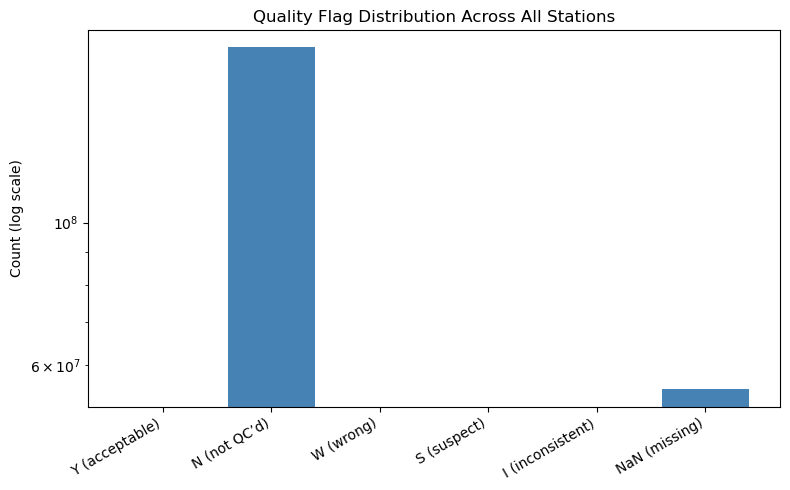

In [ ]:
# Flag code labels
flag_labels = {
    0: "Y (acceptable)",
    1: "N (not QC’d)",
    2: "W (wrong)",
    3: "S (suspect)",
    4: "I (inconsistent)",
    'Y': "Y (acceptable)",
    'N': "N (not QC’d)",
    'W': "W (wrong)",
    'S': "S (suspect)",
    'I': "I (inconsistent)",
    'NaN': "NaN (missing)"
}

all_categories = [0,1,2,3,4,'Y','N','W','S','I','NaN']
complete_counts = {c: flag_counts.get(c, 0) for c in all_categories}
labels = [flag_labels.get(c, str(c)) for c in all_categories]

# Plotting bar chart
codes = list(complete_counts.keys())
counts = list(complete_counts.values())
labels = [flag_labels[c] for c in codes]

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color="steelblue")
plt.ylabel("Count (log scale)")
plt.yscale("log")  
plt.title("Quality Flag Distribution Across All Stations")
plt.xticks(rotation=30, ha="right")

plt.tight_layout()
plt.show()

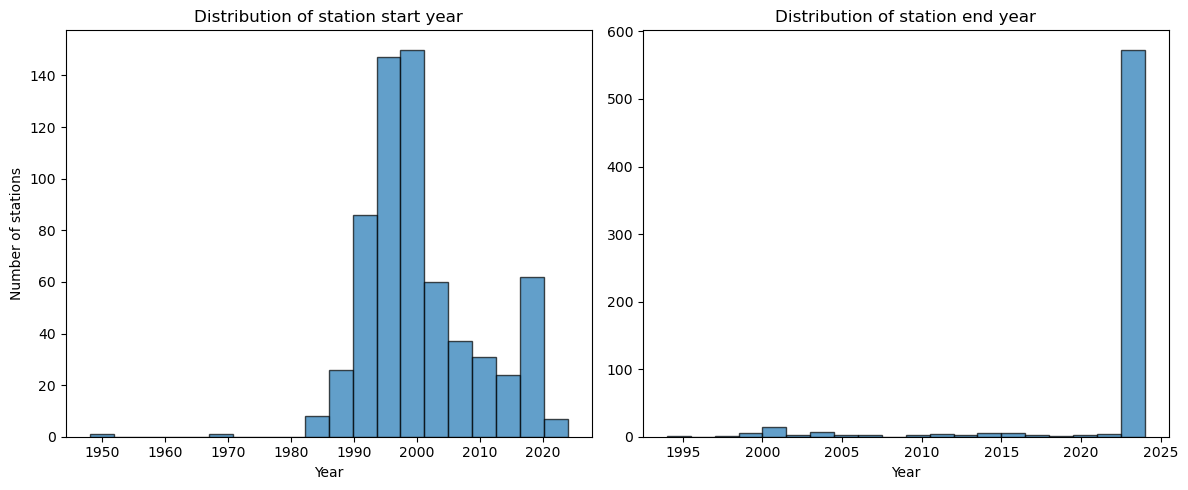

In [ ]:
# Looking for a start year to begin analysis from:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))
ax1.hist(metadata_df['Start Year'], bins=20, edgecolor="k", alpha=0.7)
ax1.set_title('Distribution of station start year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of stations')

ax2.hist(metadata_df['End Year'], bins=20, edgecolor="k", alpha=0.7)
ax2.set_title('Distribution of station end year')
ax2.set_xlabel('Year')

plt.tight_layout()
plt.show()

### 30 + yr stations:

In [9]:
# picking out how mant stations gave 30+ year record

def filter_stations_by_year(station_files, starting_year=1994, last_year = 2024):
    selected_files = []

    for file_path in station_files:
        try:
            ds = nc.Dataset(file_path, mode='r')  # open metadata only
            start_year = getattr(ds, "First_year", None)
            end_year =  getattr(ds, "Lastest_year", None)  
            ds.close()

            if start_year is not None and int(start_year) <= starting_year:
                if end_year is not None and int(end_year) >= last_year:
                    selected_files.append(file_path)

        except Exception as e:
            print(f"Failed to read {file_path}: {e}")

    return selected_files

In [10]:
thirty_years_stns = filter_stations_by_year(nc_files, starting_year=1994, last_year = 2024)

print(f"{len(thirty_years_stns)} stations with 30+ years recording")

126 stations with 30+ years recording


In [ ]:
# checking for extreme values in this data:

find_sus_values(thirty_years_stns, threshold = 500)



,Station,time,prcp_inst
0,066037,1998-05-07 03:00:00,960.0
1,062100,1993-05-10 07:30:00,800.0
2,055325,2010-10-20 05:00:00,800.0


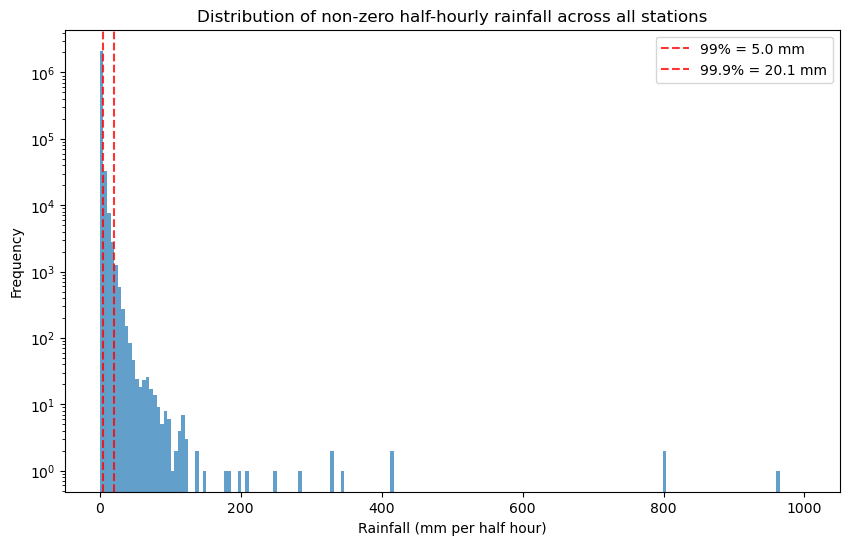

Maximum half-hourly rainfall value across stations with 30+ years record: 960.0mm


In [ ]:
# plotting distribution:

# Define bins for histogram
bins = np.linspace(0, 1000, 200)  
hist_total = np.zeros(len(bins)-1)

max_vals= []

# Loop through files one at a time
for f in thirty_years_stns:
    try:
        with xr.open_dataset(f) as ds:
            # remove zeros and NaNs
            vals = ds['prcp_inst'].values.flatten()
            vals = vals[~np.isnan(vals)]
            vals = vals[vals > 0.1] 

            if vals.size == 0:
                continue 

            # Add values to hist
            hist, _ = np.histogram(vals, bins=bins)
            hist_total += hist

            # pull out max to check outliers
            max_vals.append(vals.max())
    except Exception as e:
        print(f"Skipping {f} due to error: {e}")

# Plot histogram
plt.figure(figsize=(10,6))
plt.bar(bins[:-1], hist_total, width=np.diff(bins), align='edge', alpha=0.7)
plt.yscale("log")
plt.xlabel("Rainfall (mm per half hour)")
plt.ylabel("Frequency")
plt.title("Distribution of non-zero half-hourly rainfall across all stations")

# Percentiles from histogram
cdf = np.cumsum(hist_total) / np.sum(hist_total)
percentiles = [99, 99.9]

for p in percentiles:
    idx = np.searchsorted(cdf, p/100)
    perc_val = bins[idx]
    plt.axvline(perc_val, color="red", linestyle="--", alpha=0.8, label=f"{p}% = {perc_val:.1f} mm")

plt.legend()
plt.show()

overall_max = max(max_vals) if max_vals else None
print(f"Maximum half-hourly rainfall value across stations with 30+ years record: {overall_max}mm")

In [ ]:
# getting the metadata for these stations:

thirties_metadata_df = helper_funcs.read_stations_metadata(thirty_years_stns)

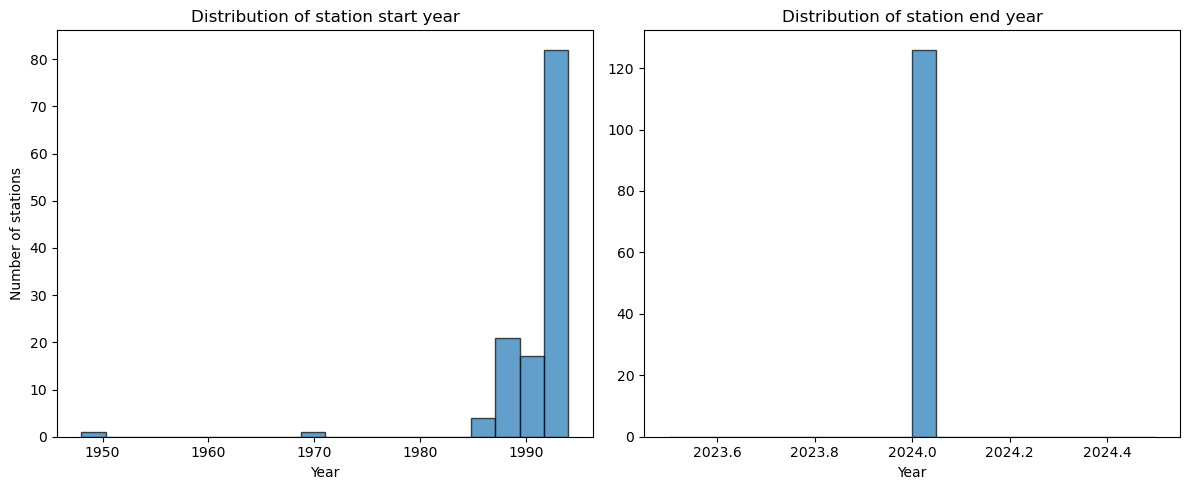

In [ ]:
# looking at the start and end years:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))
ax1.hist(thirties_metadata_df['Start Year'], bins=20, edgecolor="k", alpha=0.7)
ax1.set_title('Distribution of station start year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of stations')

ax2.hist(thirties_metadata_df['End Year'], bins=20, edgecolor="k", alpha=0.7)
ax2.set_title('Distribution of station end year')
ax2.set_xlabel('Year')

plt.tight_layout()
plt.show()



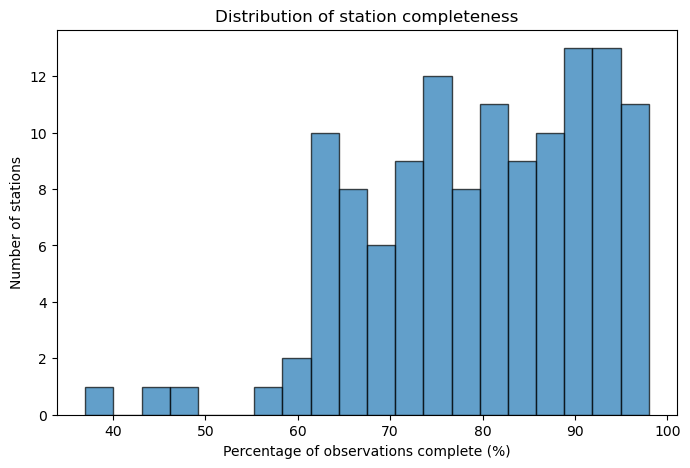

In [ ]:
# Looking at % complete of these stations:

plt.figure(figsize=(8,5))
plt.hist(thirties_metadata_df['Percentage Complete (from file)'], bins=20, edgecolor="k", alpha=0.7)
plt.xlabel("Percentage of observations complete (%)")
plt.ylabel("Number of stations")
plt.title("Distribution of station completeness")
plt.show()

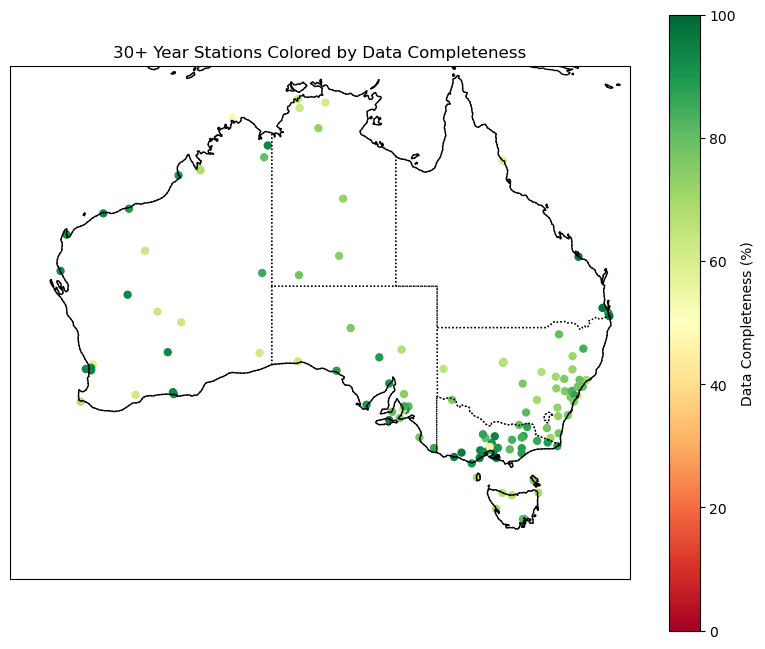

In [ ]:
# Checking where these stations are:

plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES, linestyle=':')
ax.set_extent([110, 155, -45, -10])

sc = plt.scatter(
    thirties_metadata_df['Longitude'], 
    thirties_metadata_df['Latitude'],
    c=thirties_metadata_df['Percentage Complete (from file)'],
    cmap='RdYlGn',  
    s=25,
    vmin=0, vmax=100,
    transform=ccrs.PlateCarree()
)

plt.colorbar(sc, label='Data Completeness (%)')
plt.title('30+ Year Stations Colored by Data Completeness')
plt.show()

In [ ]:
metadata_df[metadata_df['Station Number'] == "068241"]


,Station Number,Station Name,State,Latitude,Longitude,Start Year,End Year,Percentage Complete (from file),Record Length
0,068241,ALBION PARK (SHELLHARBOUR AIRPORT),NSW,-34.5639,150.7924,1999,2024,83.0,26


In [ ]:
# Extreme analysis

def extremes_contribution(daily_df, annual_df, percentiles=[90, 95, 99, 99.9], rain_level=0.1):
    """
    Compute contribution of extreme daily rainfall to annual totals globally (all stations together).
    
    Arguments:
    - daily_df: DataFrame with daily totals (index = time, columns = stations)
    - annual_df: DataFrame with annual totals (index = time, columns = stations)
    - percentiles: list of percentiles to consider
    - rain_level: minimum daily rainfall to consider (exclude near-zero values)
    
    Returns:
    - thresholds: dict of percentile thresholds (global across all stations)
    - contribution: dict of DataFrames, each DataFrame is station x year fraction (%) of annual total
    """
    
    # Flatten daily values and remove NaN and very small values
    all_daily = daily_df.values.flatten()
    all_daily = all_daily[~np.isnan(all_daily)]
    all_daily = all_daily[all_daily > rain_level]
    
    # Compute global thresholds
    thresholds = {p: np.percentile(all_daily, p) for p in percentiles}
    
    # Compute contributions
    contribution = {}
    for p in percentiles:
        q = thresholds[p]
        # Keep only days above threshold
        extreme = daily_df.where(daily_df > q, 0)
        # Sum by year
        extreme_annual = extreme.resample("Y").sum()
        # Fraction of annual totals
        contribution[p] = extreme_annual / annual_df * 100  # percent contribution
    
    return thresholds, contribution


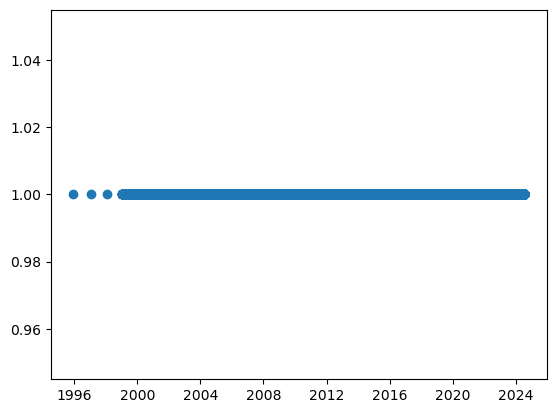

In [ ]:
ds = xr.open_dataset(tester_stations[2])
rain = ds['prcp_inst']
time = ds['time']
qual = ds['quality_flag']
plt.scatter(time, qual)
#print(rain.argmax())
#print(qual[869093].values)
ds.close()